Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

In [3]:
data=pd.read_csv('/datasets/faces/labels.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


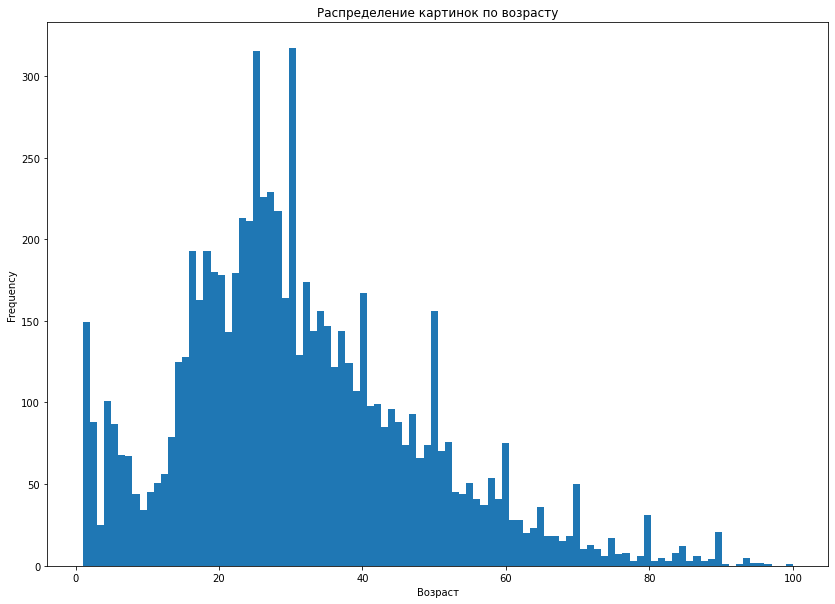

In [5]:
plt.figure(figsize=(14, 10))
data['real_age'].plot(kind='hist', bins=100, range=(1, 100))
plt.xlabel('Возраст')
plt.title('Распределение картинок по возрасту')
plt.show()

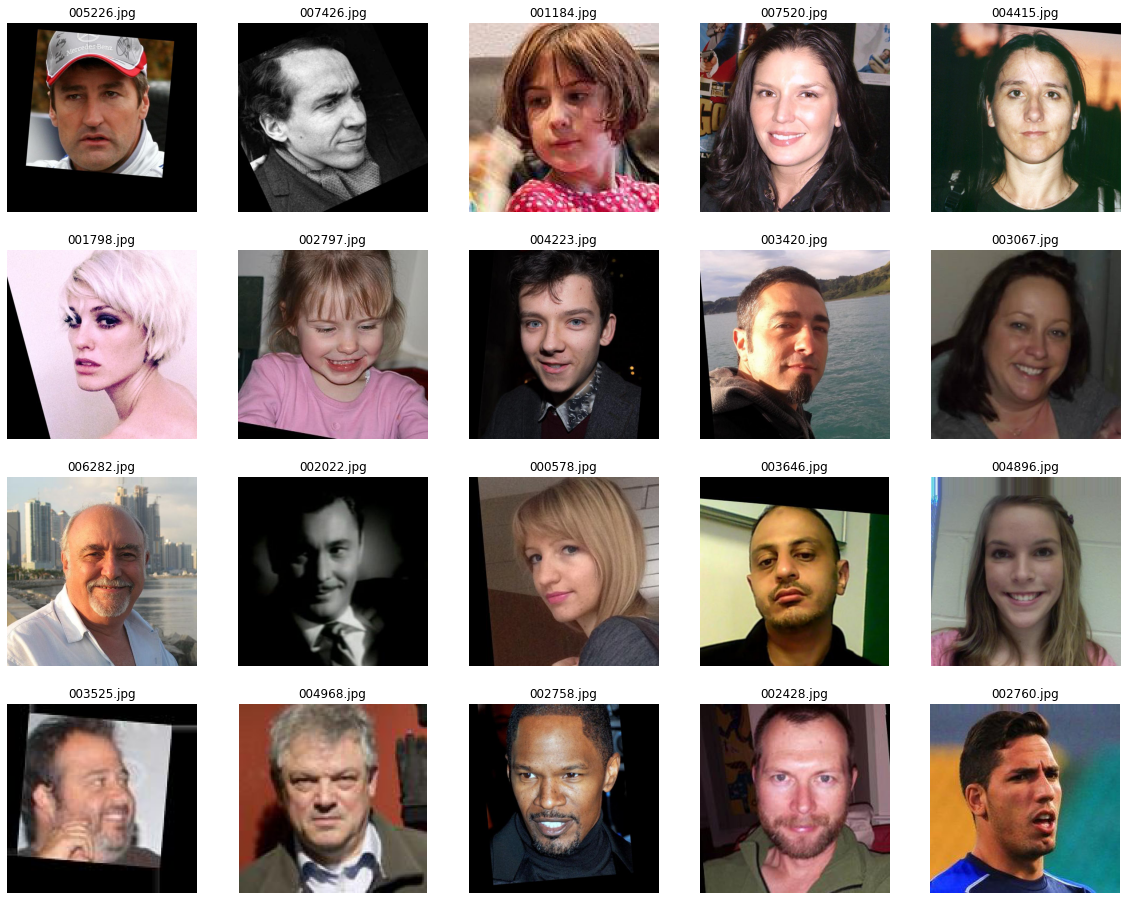

In [6]:
image_dir = '/datasets/faces/final_files'

image_files = os.listdir(image_dir)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()
for ax, img_file in zip(axes, image_files[:20]):
    img = mpimg.imread(os.path.join(image_dir, img_file))
    ax.imshow(img)
    ax.set_title(img_file)
    ax.axis('off')
plt.show()

Гистограма показывает, что на большинстве фотографий людям от 20 до 40 лет. Видно особенно большое количество фотографий в возрасте 25-30 лет. Остальных возрастных групп меньше.

Фотографии имеют одинаковый размер, нет перевернутых или неправильно расположенных изображений. Благодаря этому модель может лучше обучиться для предсказания возраста людей.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
    	
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    		  
    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```
Train for 178 steps, validate for 60 steps
Epoch 1/30
2024-07-11 08:34:56.897000: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-11 08:34:57.383660: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 104s - loss: 266.7246 - mae: 12.3944 - val_loss: 450.7970 - val_mae: 16.1486
Epoch 2/30
178/178 - 73s - loss: 183.7618 - mae: 10.4466 - val_loss: 282.0576 - val_mae: 13.0111
Epoch 3/30
178/178 - 69s - loss: 169.5409 - mae: 9.9599 - val_loss: 290.2585 - val_mae: 12.7968
Epoch 4/30
178/178 - 68s - loss: 149.8838 - mae: 9.3257 - val_loss: 272.4521 - val_mae: 12.6511
Epoch 5/30
178/178 - 68s - loss: 134.3873 - mae: 8.8013 - val_loss: 194.0790 - val_mae: 10.8595
Epoch 6/30
178/178 - 68s - loss: 126.2105 - mae: 8.6132 - val_loss: 192.5176 - val_mae: 10.5352
Epoch 7/30
178/178 - 68s - loss: 122.0485 - mae: 8.3885 - val_loss: 117.0410 - val_mae: 8.2825
Epoch 8/30
178/178 - 68s - loss: 116.3803 - mae: 8.2393 - val_loss: 151.4938 - val_mae: 9.3076
Epoch 9/30
178/178 - 78s - loss: 108.3769 - mae: 7.9240 - val_loss: 120.2862 - val_mae: 8.1806
Epoch 10/30
178/178 - 80s - loss: 108.5965 - mae: 7.9244 - val_loss: 136.9694 - val_mae: 8.4746
Epoch 11/30
178/178 - 81s - loss: 100.5392 - mae: 7.6776 - val_loss: 124.6782 - val_mae: 8.4111
Epoch 12/30
178/178 - 80s - loss: 100.1793 - mae: 7.6299 - val_loss: 111.4012 - val_mae: 7.9843
Epoch 13/30
178/178 - 81s - loss: 92.1175 - mae: 7.3306 - val_loss: 197.0796 - val_mae: 10.3199
Epoch 14/30
178/178 - 80s - loss: 93.0956 - mae: 7.3386 - val_loss: 144.1880 - val_mae: 8.7756
Epoch 15/30
178/178 - 80s - loss: 87.1657 - mae: 7.0842 - val_loss: 129.0157 - val_mae: 8.5923
Epoch 16/30
178/178 - 74s - loss: 84.8964 - mae: 6.9724 - val_loss: 127.5702 - val_mae: 8.4509
Epoch 17/30
178/178 - 72s - loss: 80.5881 - mae: 6.8460 - val_loss: 141.2409 - val_mae: 9.5260
Epoch 18/30
178/178 - 73s - loss: 80.5137 - mae: 6.8420 - val_loss: 126.5857 - val_mae: 8.3426
Epoch 19/30
178/178 - 72s - loss: 79.3402 - mae: 6.8149 - val_loss: 262.8850 - val_mae: 11.3740
Epoch 20/30
178/178 - 73s - loss: 80.3376 - mae: 6.8175 - val_loss: 150.6850 - val_mae: 8.8307
Epoch 21/30
178/178 - 73s - loss: 73.6924 - mae: 6.5411 - val_loss: 166.1260 - val_mae: 10.0851
Epoch 22/30
178/178 - 73s - loss: 74.2932 - mae: 6.5621 - val_loss: 114.1047 - val_mae: 8.2529
Epoch 23/30
178/178 - 73s - loss: 69.1286 - mae: 6.3108 - val_loss: 137.9488 - val_mae: 8.8048
Epoch 24/30
178/178 - 73s - loss: 68.2406 - mae: 6.2757 - val_loss: 101.1105 - val_mae: 7.6193
Epoch 25/30
178/178 - 73s - loss: 64.0446 - mae: 6.1216 - val_loss: 114.6314 - val_mae: 7.9070
Epoch 26/30
178/178 - 72s - loss: 60.4139 - mae: 5.9214 - val_loss: 143.4452 - val_mae: 8.8713
Epoch 27/30
178/178 - 71s - loss: 59.0110 - mae: 5.8920 - val_loss: 134.0768 - val_mae: 8.3805
Epoch 28/30
178/178 - 68s - loss: 60.9066 - mae: 6.0014 - val_loss: 152.4933 - val_mae: 9.0065
Epoch 29/30
178/178 - 68s - loss: 58.4642 - mae: 5.8674 - val_loss: 161.4629 - val_mae: 9.5435
Epoch 30/30
178/178 - 68s - loss: 60.8185 - mae: 5.9579 - val_loss: 94.0937 - val_mae: 7.1285
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 94.0937 - mae: 7.1285
Test MAE: 7.1285

## Анализ обученной модели

Целью проекта было создание модели для определения возраста людей по их изображениям. 

В датасете содержатся две колонки: имя изображения и реальный возраст. В имеющихся данных в основном представлены изображения людей от 20 до 35 лет.

Финальные значения модели после 30 эпох обучения:
val_loss: 94,0937
val_mae: 7,1285
Test MAE: 7,1285


Это означает, что модель способна предсказывать возраст людей по фотографиям с высокой точностью.

Сама модель является лишь частью проекта, поскольку модель не предлагает товары, которые могут заинтересовать покупателей этой возрастной группы и не контролирует добросовестность кассиров при продаже алкоголя, однако она определяет возраст посетителей и ее можно использовать как основу для дальнейшего осуществления бизнес-плана.